In [52]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [53]:
data

,sent_id,text,label
733,003480-02-01,morsom tegneseriefiks,1
510,201734-21-01,strømsparingsfunksjoner slått klarte maskinen ...,1
3848,105177-11-02,regissøren lagt vekt godt ensemblespill,1
3679,107375-01-01,vemodig muntert,1
3013,705034-05-01,gikk oppgaven uttrykt ønske skape magi klarte ...,1
...,...,...,...
4450,004773-07-01,middelaldrende snekkeren daniel dave johns får...,0
3522,305287-16-01,antallet låter godt halvert iii iv enkelt albu...,0
475,106487-05-02,selvsagt rystende vondt grusomt,0
3891,700556-06-02,stå klar pille vann kommer norsk manusforfatter,0


In [54]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 12127


<AxesSubplot:>

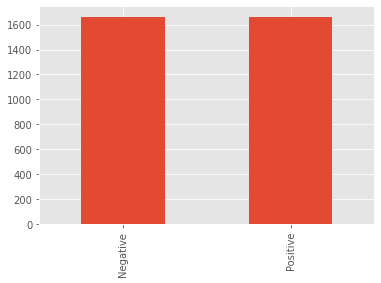

In [55]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

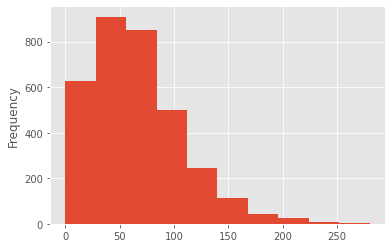

In [56]:
data["text"].str.len().plot.hist()

In [57]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data["text"])
sequences = tokenizer.texts_to_sequences(data["text"])

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

padded_data = pad_sequences(sequences, maxlen=100)

Found 12126 unique tokens.


In [58]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
labels = encoder.fit_transform(data["label"])
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, test_size=0.2, random_state=42)

In [59]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2660, 100) (2660, 2)
(666, 100) (666, 2)


In [61]:
from backend.src.utils.embeddings import load_embeddings

embeddings_index = load_embeddings()

In [62]:
import numpy as np

vocab_size = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [63]:
from keras import Input
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Input(shape=(embedding_dim,), dtype="float32", name="review_input"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [64]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1212700   
                                                                 
 review_input (InputLayer)   multiple                  0         
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               1000100   
                                                                 
 dense_10 (Dense)            (None, 32)                3232      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 2,216,098
Trainable params: 1,003,398
No

In [65]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 50
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
167/167 [==============================] - 4s 17ms/step - loss: 0.6760 - accuracy: 0.5823 - val_loss: 0.6683 - val_accuracy: 0.5946
Epoch 2/50
167/167 [==============================] - 2s 14ms/step - loss: 0.5522 - accuracy: 0.7169 - val_loss: 0.6724 - val_accuracy: 0.5946
Epoch 3/50
167/167 [==============================] - 2s 13ms/step - loss: 0.4066 - accuracy: 0.8139 - val_loss: 0.8169 - val_accuracy: 0.5901
Epoch 4/50
167/167 [==============================] - 2s 15ms/step - loss: 0.2382 - accuracy: 0.9120 - val_loss: 0.9715 - val_accuracy: 0.6006
Epoch 5/50
167/167 [==============================] - 2s 15ms/step - loss: 0.1150 - accuracy: 0.9654 - val_loss: 1.2861 - val_accuracy: 0.5886
Epoch 6/50
167/167 [==============================] - 2s 13ms/step - loss: 0.0577 - accuracy: 0.9835 - val_loss: 1.5838 - val_accuracy: 0.5826
Epoch 7/50
167/167 [==============================] - 2s 11ms/step - loss: 0.0325 - accuracy: 0.9917 - val_loss: 1.8915 - val_accuracy: 0.5901

In [66]:
from datetime import datetime

model.save(f"models/SA-GLOVE-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

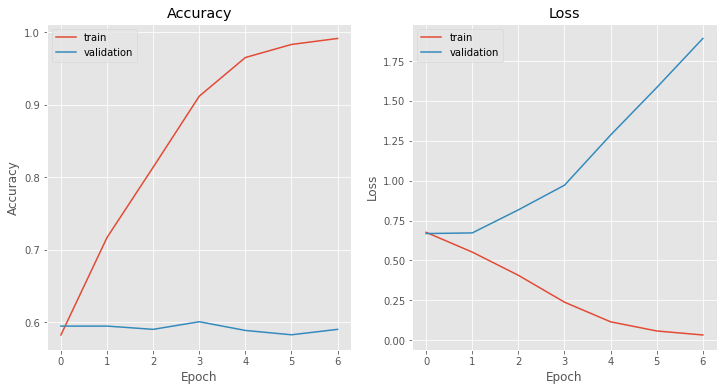

In [67]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [68]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

21/21 [==============================] - 0s 13ms/step - loss: 1.8915 - accuracy: 0.5901
Validation loss: 1.8914587497711182
Validation accuracy: 0.5900900959968567
